#### 라이브러리 호출

In [24]:
import logging  # to further silence deprecation warnings
import warnings
from warnings import filterwarnings

# Standard library
import os

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & clustering
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
from umap import validation
import hdbscan
from hdbscan.validity import validity_index

# Custom modules
from denseclus import DenseClus

# Suppress the specific FutureWarning from sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

logging.captureWarnings(True)

In [25]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

#### 데이터 호출

In [27]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_path = './data/flat-training.csv'

df = pd.read_csv(data_path)

# 결측치가 하나라도 있는 열을 제거
df = df.dropna(axis=1)

# random sampling 진행
#df = df.sample(n=20000, random_state=SEED)

df.head(5)

,dog,cat,deer,panda,koala,otter,hedgehog,squirrel,dolphin,penguin,...,blanket,button,whistle,marble,wagon,storybook,candle,clover,bubble,cookie
0,10,A5DB,4.46,-2,T2,B9DE,51.8,0,1,20,...,A8,2,2,0,-0.76,-54,B2,0.38,0,C13
1,10,A5DB,4.42,0,T3,027A,72.2,1,1,20,...,A7,16,0,0,-0.76,-48,B0,0.16,0,C15
2,43,027A,3.11,-1,T0,B9DE,44.2,1,1,20,...,A4,-25,10,0,-0.88,-39,B0,0.13,0,C1
3,28,63D1,3.37,-1,T1,027A,41.0,0,1,20,...,A3,21,9,0,-0.85,-58,B1,0.29,1,C5
4,82,C09E,3.07,-6,T0,B9DE,46.4,1,1,20,...,A7,-4,13,0,-0.85,70,B2,0.75,1,C13


In [28]:
df.dtypes

dog            int64
cat           object
deer         float64
panda          int64
koala         object
              ...   
storybook      int64
candle        object
clover       float64
bubble         int64
cookie        object
Length: 76, dtype: object

#### 모델 학습

In [30]:
# 하이퍼파라미터 호출
umap_params = {'categorical': {'n_neighbors': 15, 'min_dist': 0.0}, 
               'numerical': {'n_neighbors': 20, 'min_dist': 0.2}, 
               'combined': {'n_neighbors': 10, 'min_dist': 0.2}}

hdbscan_params = {'min_samples': 50, 'min_cluster_size': 200, 'gen_min_span_tree': True}

clf = DenseClus(
    random_state=SEED,
    hdbscan_params=hdbscan_params,
    umap_params=umap_params,
    umap_combine_method="intersection_union_mapper"
)

clf.fit(df)

Max of 90 is greater than threshold 25
Hashing categorical features


In [31]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"], ignore_index=True))

Coverage 0.93553
Calinski-Harabasz Score: 4193.521452382333
    cluster  count
0        -1   6447
1         0    789
2         1    897
3         2    263
4         3    212
5         4   1856
6         5    662
7         6    781
8         7    760
9         8   3368
10        9    455
11       10    507
12       11    371
13       12    352
14       13   1052
15       14    684
16       15   3796
17       16   1037
18       17    397
19       18    479
20       19    229
21       20    495
22       21   3356
23       22    288
24       23   3197
25       24   1552
26       25    419
27       26    242
28       27   1039
29       28    678
30       29    335
31       30    478
32       31    411
33       32   1597
34       33    211
35       34    209
36       35   1559
37       36    440
38       37    368
39       38    296
40       39   1903
41       40   1868
42       41    259
43       42    362
44       43   1547
45       44    236
46       45    408
47       46    787
48       

In [32]:
embedding.shape

(100000, 5)

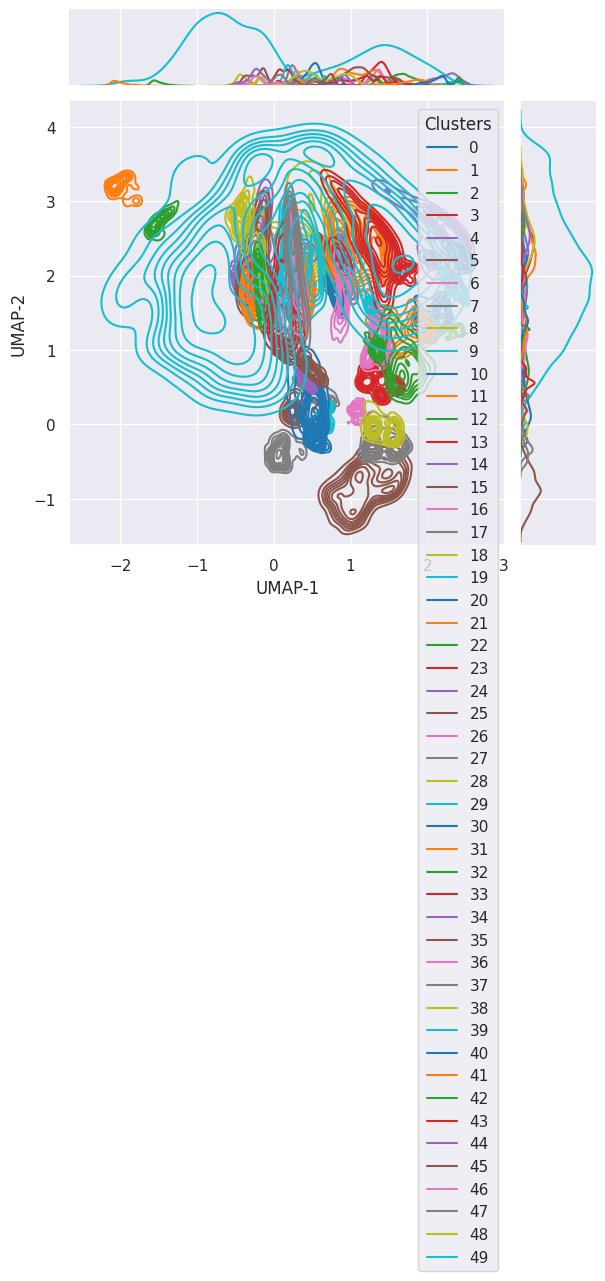

In [34]:
g = sns.jointplot(
    x=embedding[clustered, 0], 
    y=embedding[clustered, 1], 
    hue=labels[clustered], 
    kind="kde", palette='tab10' )

g.set_axis_labels("UMAP-1", "UMAP-2")

legend = g.ax_joint.get_legend()
if legend:
    legend.set_title("Clusters")

plt.show()

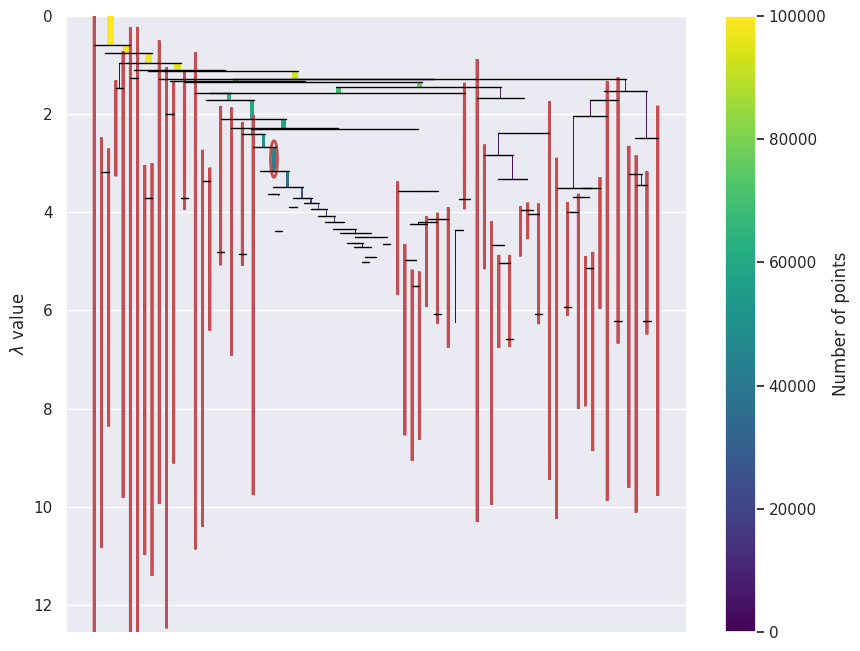

In [35]:
clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

plt.show()

In [36]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 0.93553
DBCV score 0.12740609936745437


In [ ]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

plt.show()

In [ ]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


plt.plot(numerical_trustworthiness)
plt.plot(categorical_trustworthiness)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")

plt.legend(["numerical T", "categorical T"], loc="upper right")

plt.show()

#### 클러스터링 결과 저장

In [ ]:
SAVE_PATH = './results'

df['segment'] = clf.evaluate()

# CSV로 저장
df.to_csv(os.path.join(SAVE_PATH, "clustered_data.csv"), index=False)